In [445]:

from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

diabetes = datasets.load_diabetes(as_frame=True)
X = diabetes.data
y = diabetes.target
control_cols = ['bmi','bp']
control_cols = ['s5','s6']
y = np.random.uniform(low=50,high=200,size=len(y))
y =  np.random.normal(40, 140, len(y))

for col in control_cols:
    # X[col] = np.random.normal(0.5, 0.3, len(y))
    X[col] = np.random.uniform(low=0,high=1,size=len(y))
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\1829529130.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = np.random.uniform(low=0,high=1,size=len(y))


In [446]:
X[control_cols].describe()

,s5,s6
count,442.000000,442.000000
mean,0.490754,0.499489
std,0.290404,0.282207
min,0.000360,0.005482
25%,0.249006,0.249672
50%,0.491917,0.489926
75%,0.736760,0.746184
max,0.999130,0.987385


In [447]:
y.mean()

np.float64(98.27564797822238)

In [448]:
params = {
    "n_estimators": 1000,
    "max_depth": 4,
    "min_samples_split": 4,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X, y)

mse = mean_squared_error(y, reg.predict(X))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 352.9934


C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\523506991.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


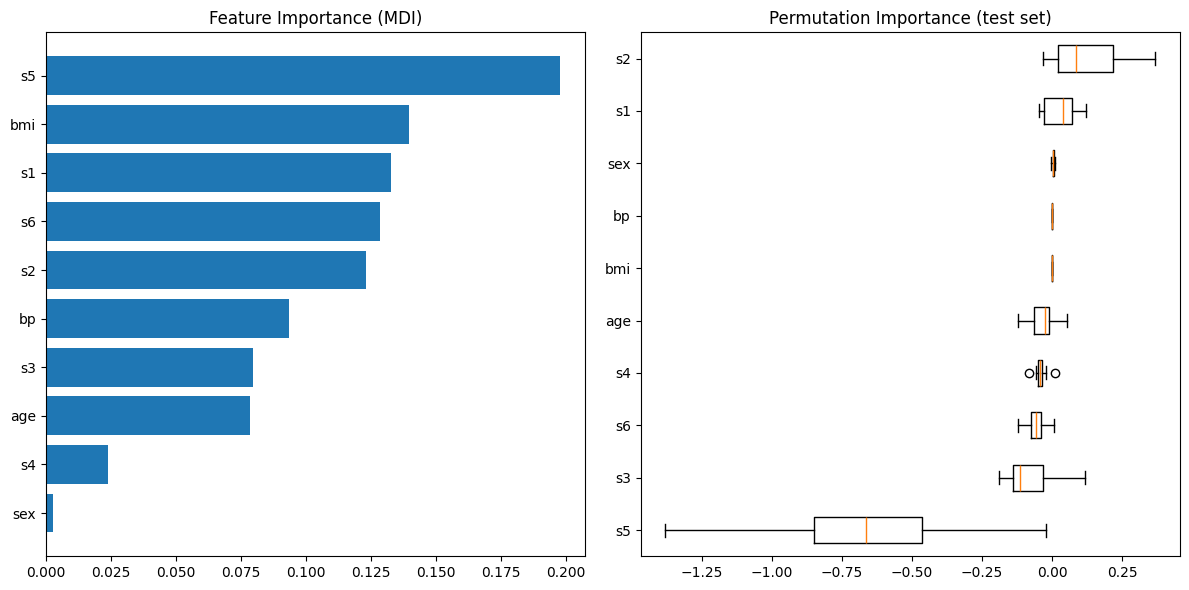

In [449]:
import matplotlib.pyplot as plt
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(diabetes.feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(diabetes.feature_names)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [450]:
def make_model_prediction(chromosome = []):
    global reg,control_cols,X
    for i,col in enumerate(control_cols):
        X[col] = chromosome[i]
    return np.mean(reg.predict(X))
        
    

In [451]:
import random
import datetime

import multiprocessing
import numpy as np

from deap import base
from deap import creator
from deap import tools
from deap.gp import mutUniform

In [452]:
NGEN = 10 # Number of Generation
POPSIZE = 100 # Number of individual in population
CXPB = 0.5 #Crossover probability
MUTB = 0.2
NDIM = len(control_cols) # Number of dimension of the individual (=number of gene)
bounds = {"key":{col:(X[col].min(), X[col].max()) for col in control_cols} }

In [453]:
import pandas as pd
import numpy as np
import random
from deap import base
from deap import creator
from deap import tools
from math import factorial
def checkBounds(loc):
    global bounds,control_cols
  
    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    minv,maxv = bounds[loc][control_cols[i]]
                    
                    if child[i] > maxv:
                        child[i] = random.uniform(minv,maxv)
                    elif child[i] < minv:
                        child[i] = random.uniform(minv,maxv)
            return offspring
        return wrapper
    return decorator
def evaluate_multi(chromosome,loc='key'):
    # W = {'kpi1': 0.9,'kpi2':0.1}
    objective1 = np.mean(chromosome)
    objective2 = make_model_prediction(chromosome = chromosome)
    print(f'objective1:{objective1} objective2:{objective2}')    
    ## chromosome 1 -> (10,20) , chromosome2-> (9,19) chromosome 3 (8,21)
    return round(objective1,2), round(objective1,2) 
def multi_objective_ga(loc="key",directions = ['min','min'],w = None,run = -1):
    global CXPB, MUTPB, NGEN,POPSIZE,control_cols,X
    print(f'Running multiobjective GA for loc : {loc} run#{run}')
    if len(directions) < 2:
      return
  
    d2w = {'min': -1.0,'max': 1.0}
    IND_SIZE = len(control_cols)
   
    if w == None:
      w1 = d2w[directions[0]]
      w2 = d2w[directions[1]]
      w = (w1,w2)
    creator.create("Fitness", base.Fitness, weights=w)
    creator.create("chromosome", list, fitness=creator.Fitness)

    toolbox = base.Toolbox()
    for i,col in enumerate(control_cols):
      dtype = str(X.dtypes[col])
      method = random.uniform
      if dtype == 'int64':
        method = random.randint
      b1,b2 = bounds[loc][col]
      name = f'feature{i+1}'
      toolbox.register(name,  method,b1,b2)
    k = len(control_cols)
    #will need as many if branches as there are elements in control_cols
    if k == 1:
      toolbox.register("chromosome", tools.initCycle, creator.chromosome,
                    (toolbox.feature1), n=1)
    
    if k == 2:
      toolbox.register("chromosome", tools.initCycle, creator.chromosome,
                    (toolbox.feature1, toolbox.feature2), n=1)
      
    
    chrom = toolbox.chromosome()
    toolbox.register("mate", tools.cxBlend, alpha=0.2)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=2,indpb=0.1)
    toolbox.decorate("mate", checkBounds(loc))
    toolbox.decorate("mutate", checkBounds(loc))
    toolbox.register("select", tools.selNSGA2,nd='log')
    toolbox.register("evaluate", evaluate_multi,loc = loc)
    toolbox.register("population", tools.initRepeat, list, toolbox.chromosome)
    
    pareto = tools.ParetoFront()
    pop = toolbox.population(n=POPSIZE)
    p =len(pop)
    # pop[p-1] = [X[col].mean() for col in control_cols]
    

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    chromosomes = {}
    evaluations = {}
    
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
        

    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    
    pop = toolbox.select(pop, len(pop))
    
    all_1 = all([x <1 for x in chrom for chrom in pop])
    print('####POP#######')
    print(pop)
    
    gen = 0
    chromosomes[gen] = pop
    evaluations[gen] = [evaluate_multi(v,loc = loc) for v in pop]
    

    # Begin the generational process
    for gen in range(1, NGEN +1):
        print(f'iteration # {gen}')
        
        # Vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]

        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= CXPB:
                toolbox.mate(ind1, ind2)
                
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            

        # Select the next generation population
        pop = toolbox.select(pop + offspring, POPSIZE)
        chromosomes[gen] = pop
        evaluations[gen] = [evaluate_multi(v,loc = loc) for v in pop]
        # all_1 = all([x <1 for x in chrom for chrom in pop])
        # print(all_1)
        

    pareto.update(pop)
    del creator.Fitness,creator.chromosome
    return pop, pareto,chromosomes,evaluations

In [454]:
from collections import defaultdict
pops_single = {}
evaluations_single = {}
chromosomes_single = {}

runs = range(1)
pops_multi = defaultdict(dict)
evaluations_multi =  defaultdict(dict)
chromosomes_multi = defaultdict(dict)
paretos_multi = defaultdict(dict)

for run in runs:
    pop, pareto,all_chromosomes,all_evaluations =  multi_objective_ga(loc="key",directions = ['min','max'],w = None,run = 1)
    chromosomes_multi[run] = all_chromosomes
    evaluations_multi[run] =all_evaluations
    pops_multi[run] = pop
    paretos_multi[run] = pareto
      


      
    
    
      
    
    

Running multiobjective GA for loc : key run#1
objective1:0.5456188010162695 objective2:99.82550713829056
objective1:0.23987655861114845 objective2:99.26168916748755
objective1:0.4861744561019098 objective2:100.77433647785884
objective1:0.5658152271574326 objective2:101.88831690665673
objective1:0.09186018926433295 objective2:108.47905835033353
objective1:0.7268445607136198 objective2:92.5438445696392
objective1:0.3587199450645807 objective2:95.84459233504256
objective1:0.26799115613240054 objective2:106.43055816967743
objective1:0.16608545568890218 objective2:95.7577750012623
objective1:0.3880644355947096 objective2:104.90841055187825
objective1:0.6948160609703362 objective2:90.34299244928597
objective1:0.6932740785800091 objective2:92.66723113341338
objective1:0.23060169279154205 objective2:94.77278176069314
objective1:0.5121217376691097 objective2:91.27713349866892
objective1:0.5470746459853089 objective2:93.502258429073
objective1:0.6414027184961872 objective2:91.88287599433679
obje

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.3331109118362555 objective2:110.42168428407837
objective1:0.5624724550327499 objective2:94.4945011533455
objective1:0.49217204258501607 objective2:101.46398133780522
objective1:0.5958176061192555 objective2:101.62787907128278
objective1:0.629595486736529 objective2:104.50435852937365
objective1:0.5128575595996797 objective2:101.14845143379675
objective1:0.07028106756046594 objective2:99.14367732377761
objective1:0.8704462121852854 objective2:97.76783217435376
objective1:0.5735463817841888 objective2:97.2796534752588
objective1:0.19978866428251377 objective2:99.34576766507536
objective1:0.4574882968570497 objective2:104.1035228178673
objective1:0.24343761090467989 objective2:101.45268676079921
objective1:0.5009214854046633 objective2:101.01275476279649
objective1:0.35024137404355926 objective2:79.88036289222872
objective1:0.5008720045393401 objective2:90.90614413027379
objective1:0.5460785843947055 objective2:102.56699258231494
objective1:0.7899508559459176 objective2:95.00

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.7218600829809735 objective2:95.20946390531473
objective1:0.42368039366614907 objective2:99.71448595579587
objective1:0.4319212518830361 objective2:99.3505802354054
objective1:0.6364488601879741 objective2:98.14684884338912
objective1:0.4735690248482861 objective2:91.00929931126684
objective1:0.8247701902319982 objective2:105.49493598595866
objective1:0.04570788138999013 objective2:107.93582541770543
objective1:0.4708416587289954 objective2:94.12667781574534
objective1:0.5798303984120328 objective2:98.3560796829831
objective1:0.6441299849309419 objective2:91.2850868334366
objective1:0.23909514723031403 objective2:107.91759950894024
objective1:0.17057187165141044 objective2:94.60678057619322
objective1:0.8488391702902254 objective2:94.73663606310564
objective1:0.2616247151242842 objective2:99.17560008704604
objective1:0.12885295358419785 objective2:98.75162764703879
objective1:0.33276193903208867 objective2:109.51900437296531
objective1:0.3414317714338278 objective2:98.95077

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.596903322958487 objective2:102.40120431131952
objective1:0.6269562700307972 objective2:100.39651216769279
objective1:0.4245233817113306 objective2:99.79960282609179
objective1:0.32062902815495153 objective2:96.76860887772253
objective1:0.6624426443305559 objective2:92.00416927416862
objective1:0.4208612703234309 objective2:100.29975923743568
objective1:0.5640001423712835 objective2:92.46948489906013
objective1:0.30472412401460147 objective2:102.41768226474865
objective1:0.5309918857412479 objective2:101.00661501994752
objective1:0.7886564703428078 objective2:92.10192244824589
objective1:0.8901789484770297 objective2:97.55254382767961
objective1:0.7177138557444859 objective2:98.0443495793575
objective1:0.46602946298376013 objective2:103.26722737776619
objective1:0.11732771323424943 objective2:101.30998364670145
objective1:0.7008869581410277 objective2:90.02918217018724
####POP#######
[[np.float64(0.0007915437042299918), np.float64(0.0747826641328168)], [np.float64(0.9759530

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.30472412401460147 objective2:102.41768226474865
objective1:0.37105392933105663 objective2:96.76193593375419
objective1:0.3880644355947096 objective2:104.90841055187825
objective1:0.43553410734673514 objective2:98.53208399236455
objective1:0.7899508559459176 objective2:95.00531302396273
objective1:0.07028106756046594 objective2:99.14367732377761
objective1:0.18022548227911356 objective2:94.50600276872505
objective1:0.40220223487797574 objective2:92.3734490821134
objective1:0.6948160609703362 objective2:90.34299244928597
objective1:0.7886564703428078 objective2:92.10192244824589
objective1:0.23909514723031403 objective2:107.91759950894024
objective1:0.2622933313766768 objective2:98.19445143149326
objective1:0.3075045411619183 objective2:103.16736729056917
objective1:0.32062902815495153 objective2:96.76860887772253
objective1:0.3587199450645807 objective2:95.84459233504256
objective1:0.4574882968570497 objective2:104.1035228178673
objective1:0.48059631828207283 objective2:114

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.3414317714338278 objective2:98.95077506328973
objective1:0.35024137404355926 objective2:79.88036289222872
objective1:0.42368039366614907 objective2:99.71448595579587
objective1:0.2616247151242842 objective2:99.17560008704604
objective1:0.3331109118362555 objective2:110.42168428407837
objective1:0.33280008797142924 objective2:101.73434616459258
objective1:0.4208612703234309 objective2:100.29975923743568
objective1:0.4319212518830361 objective2:99.3505802354054
objective1:0.4328827904084536 objective2:98.44372933021674
objective1:0.46602946298376013 objective2:103.26722737776619
objective1:0.4861744561019098 objective2:100.77433647785884
objective1:0.49217204258501607 objective2:101.46398133780522
objective1:0.5009214854046633 objective2:101.01275476279649
objective1:0.5008720045393401 objective2:90.90614413027379
objective1:0.5121217376691097 objective2:91.27713349866892
objective1:0.5460785843947055 objective2:102.56699258231494
objective1:0.5624724550327499 objective2:94.

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.5658152271574326 objective2:101.88831690665673
objective1:0.23932923484208557 objective2:98.40914322609132
objective1:0.23946464080304442 objective2:96.1932927017016
objective1:0.24343761090467989 objective2:101.45268676079921
objective1:0.33276193903208867 objective2:109.51900437296531
objective1:0.4245233817113306 objective2:99.79960282609179
objective1:0.455208600720936 objective2:97.15450178711782
objective1:0.45992772191219483 objective2:117.62522660729272
objective1:0.4708416587289954 objective2:94.12667781574534
objective1:0.5076831356031156 objective2:100.04481551979728
objective1:0.5470746459853089 objective2:93.502258429073
objective1:0.5611122697862282 objective2:101.2150804405922
objective1:0.5573274866396806 objective2:98.65884752369838
objective1:0.5728173589563297 objective2:99.52267327850645
objective1:0.5735463817841888 objective2:97.2796534752588
objective1:0.5703428166521644 objective2:90.62305584217602
objective1:0.5673859534388088 objective2:94.4584264

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.16608545568890218 objective2:95.7577750012623
objective1:0.5128575595996797 objective2:101.14845143379675
objective1:0.5728173589563297 objective2:99.52267327850645
objective1:0.09210362642252756 objective2:106.17978619549889
objective1:0.5200750854500186 objective2:100.89274487428486
objective1:0.5008720045393401 objective2:90.90614413027379
objective1:0.23733269756528216 objective2:98.86776497994748
objective1:0.3756784765361123 objective2:96.57381787658773
objective1:0.6763732667747074 objective2:93.4490157107853
objective1:0.48923642488684443 objective2:100.5344444075542
objective1:0.4027102295944089 objective2:100.84077224954537
objective1:0.3724042743637038 objective2:96.63802071348096
objective1:0.3773235746596441 objective2:96.49661529085407
objective1:0.620696266337587 objective2:89.97929365512374
objective1:0.41724317717285136 objective2:100.29975923743568
objective1:0.6317977172166203 objective2:105.50583932839835
objective1:0.5308001566316487 objective2:101.006

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.35024137404355926 objective2:79.88036289222872
objective1:0.30472412401460147 objective2:102.41768226474865
objective1:0.629595486736529 objective2:104.50435852937365
objective1:0.07028106756046594 objective2:99.14367732377761
objective1:0.4939220592258876 objective2:91.2902969049018
objective1:0.14707871497244362 objective2:98.18510770977488
objective1:0.7481559322835938 objective2:105.79071305977926
objective1:0.4054073620212331 objective2:99.69561190642438
objective1:0.23383659089432882 objective2:99.26168916748755
objective1:0.4306589753603237 objective2:91.98337156198185
objective1:0.7177138557444859 objective2:98.0443495793575
objective1:0.23909514723031403 objective2:107.91759950894024
objective1:0.5456334126254162 objective2:97.89534691327049
objective1:0.8448112365692386 objective2:100.12521885317658
objective1:0.8247701902319982 objective2:105.49493598595866
objective1:0.32062902815495153 objective2:96.76860887772253
objective1:0.48059631828207283 objective2:114.

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.8488391702902254 objective2:94.73663606310564
objective1:0.7268445607136198 objective2:92.5438445696392
objective1:0.596903322958487 objective2:102.40120431131952
objective1:0.5309918857412479 objective2:101.00661501994752
objective1:0.5587187874959944 objective2:91.07379954367707
objective1:0.5790078914213161 objective2:100.92451687150349
objective1:0.19213430782631344 objective2:104.60130974610809
objective1:0.7024704174265365 objective2:94.21724449242829
objective1:0.09186018926433295 objective2:108.47905835033353
objective1:0.9544860807645068 objective2:102.02590734186892
objective1:0.8704462121852854 objective2:97.76783217435376
objective1:0.11732771323424943 objective2:101.30998364670145
objective1:0.5998230667157798 objective2:101.79061916088313
objective1:0.48305742984926614 objective2:101.44606855783996
objective1:0.2816806848378207 objective2:96.67913218274221
objective1:0.5844996687859665 objective2:98.65174089292982
objective1:0.13167725269422548 objective2:102

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.5200750854500186 objective2:100.89274487428486
objective1:0.5309918857412479 objective2:101.00661501994752
objective1:0.5456188010162695 objective2:99.82550713829056
objective1:0.5844996687859665 objective2:98.65174089292982
objective1:0.5958176061192555 objective2:101.62787907128278
objective1:0.6441299849309419 objective2:91.2850868334366
objective1:0.6624426443305559 objective2:92.00416927416862
objective1:0.6629532987723914 objective2:91.32473369145049
objective1:0.7899508559459176 objective2:95.00531302396273
objective1:0.8448112365692386 objective2:100.12521885317658
objective1:0.8488391702902254 objective2:94.73663606310564
objective1:0.8664884285348842 objective2:93.69823500047421
objective1:0.8704462121852854 objective2:97.76783217435376
objective1:0.05950949809234478 objective2:181.25921583049757
objective1:0.04570788138999013 objective2:107.93582541770543
objective1:0.07028106756046594 objective2:99.14367732377761
objective1:0.09186018926433295 objective2:108.47

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.4306589753603237 objective2:91.98337156198185
objective1:0.4708416587289954 objective2:94.12667781574534
objective1:0.48059631828207283 objective2:114.35255940594882
objective1:0.48305742984926614 objective2:101.44606855783996
objective1:0.4861744561019098 objective2:100.77433647785884
objective1:0.49217204258501607 objective2:101.46398133780522
objective1:0.5009214854046633 objective2:101.01275476279649
objective1:0.5008720045393401 objective2:90.90614413027379
objective1:0.5128575595996797 objective2:101.14845143379675
objective1:0.5128575595996797 objective2:101.14845143379675
objective1:0.5309918857412479 objective2:101.00661501994752
objective1:0.5485798945781775 objective2:104.4585734761883
objective1:0.5624724550327499 objective2:94.4945011533455
objective1:0.5650757544305058 objective2:92.63222498866047
objective1:0.5752542238845607 objective2:100.111153619332
objective1:0.5998230667157798 objective2:101.79061916088313
objective1:0.6077907284902168 objective2:98.27

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.3724042743637038 objective2:96.63802071348096
objective1:0.6629532987723914 objective2:91.32473369145049
objective1:0.5128575595996797 objective2:101.14845143379675
objective1:0.9544860807645068 objective2:102.02590734186892
objective1:0.11732771323424943 objective2:101.30998364670145
objective1:0.629595486736529 objective2:104.50435852937365
objective1:0.3098099570627582 objective2:102.06565616149693
objective1:0.7077149700949709 objective2:105.62937191791373
objective1:0.42368039366614907 objective2:99.71448595579587
objective1:0.12885295358419785 objective2:98.75162764703879
objective1:0.41153370489256497 objective2:109.03572327524199
objective1:0.313618055750412 objective2:96.73280397235875
objective1:0.49863798487902866 objective2:102.81908868333961
objective1:0.11732771323424943 objective2:101.30998364670145
objective1:0.2645787908854685 objective2:95.94626456186775
objective1:0.2784160800790349 objective2:93.78063108706233
objective1:0.34000444488888504 objective2:9

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.8285546459408909 objective2:85.82449675632158
objective1:0.3650265820539299 objective2:98.79901454333303
objective1:0.49217204258501607 objective2:101.46398133780522
objective1:0.5958176061192555 objective2:101.62787907128278
objective1:0.13167725269422548 objective2:102.18039798057426
objective1:0.8488391702902254 objective2:94.73663606310564
objective1:0.6641575036228908 objective2:94.03066198453475
objective1:0.2585709453314438 objective2:96.95359789426834
objective1:0.6077907284902168 objective2:98.27481390175176
objective1:0.22758174458142022 objective2:99.31533563753474
objective1:0.7733962442504209 objective2:96.54698078743108
objective1:0.5790270667282467 objective2:91.67461146045659
objective1:0.20804212636345082 objective2:94.79938869072771
objective1:0.4875953183658714 objective2:100.227155717334
objective1:0.3880644355947096 objective2:104.90841055187825
objective1:0.516194722568353 objective2:100.82389363427525
objective1:0.2605711271113663 objective2:98.76248

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.7596231490568577 objective2:95.9378912373768
objective1:0.8664884285348842 objective2:93.69823500047421
objective1:0.26799115613240054 objective2:106.43055816967743
objective1:0.5172938877271873 objective2:103.57695035445828
objective1:0.04570788138999013 objective2:107.93582541770543
objective1:0.47831004027189383 objective2:101.67559678625088
objective1:0.4709124596521507 objective2:99.86442487106639
objective1:0.2849678261202595 objective2:115.98475547025629
objective1:0.7610497568169884 objective2:96.83650980656965
objective1:0.4432699363500291 objective2:100.63585671825307
objective1:0.3075045411619183 objective2:103.16736729056917
objective1:0.37012665651321974 objective2:98.942793682244
objective1:0.4185976134106486 objective2:103.6001957085226
objective1:0.43553410734673514 objective2:98.53208399236455
objective1:0.8488391702902254 objective2:94.73663606310564
objective1:0.24145978765993015 objective2:98.88421514677766
objective1:0.2982288901845178 objective2:95.40

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.74167433665867 objective2:97.83874461124228
objective1:0.7888880932358157 objective2:96.09941717041843
objective1:0.8662326301767549 objective2:94.92447001525649
objective1:0.23694183745566189 objective2:94.95228975992991
objective1:0.2052127315172534 objective2:96.50731090306348
objective1:0.8298947142124324 objective2:95.0626454439484
objective1:0.768721351483016 objective2:95.26844071365704
objective1:0.6624426443305559 objective2:92.00416927416862
objective1:0.07028106756046594 objective2:99.14367732377761
objective1:0.09186018926433295 objective2:108.47905835033353
objective1:0.14707871497244362 objective2:98.18510770977488
objective1:0.4862034952510058 objective2:100.5344444075542
objective1:0.5401791368859977 objective2:104.2860589924062
objective1:0.5752542238845607 objective2:100.111153619332
objective1:0.5995000515692795 objective2:98.46019816549483
objective1:0.8706311583862159 objective2:94.71891530169296
objective1:0.7027371258181436 objective2:92.843638058323

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.6744576918200018 objective2:92.52634011823078
objective1:0.7268445607136198 objective2:92.5438445696392
objective1:0.7627997632998251 objective2:95.34756257173075
objective1:0.7796828050173228 objective2:95.21572314475154
objective1:0.7888880932358157 objective2:96.09941717041843
objective1:0.8448112365692386 objective2:100.12521885317658
objective1:0.8488391702902254 objective2:94.73663606310564
objective1:0.8664884285348842 objective2:93.69823500047421
objective1:0.8706311583862159 objective2:94.71891530169296
objective1:0.8901789484770297 objective2:97.55254382767961
objective1:0.05950949809234478 objective2:181.25921583049757
objective1:0.07028106756046594 objective2:99.14367732377761
objective1:0.09186018926433295 objective2:108.47905835033353
objective1:0.13167725269422548 objective2:102.18039798057426
objective1:0.14707871497244362 objective2:98.18510770977488
objective1:0.18022548227911356 objective2:94.50600276872505
objective1:0.19978866428251377 objective2:99.34

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.32062902815495153 objective2:96.76860887772253
objective1:0.3331109118362555 objective2:110.42168428407837
objective1:0.3319878506145205 objective2:96.67407235495746
objective1:0.3414317714338278 objective2:98.95077506328973
objective1:0.35024137404355926 objective2:79.88036289222872
objective1:0.3587199450645807 objective2:95.84459233504256
objective1:0.36345677857075437 objective2:100.36149576355885
objective1:0.37105392933105663 objective2:96.76193593375419
objective1:0.37012665651321974 objective2:98.942793682244
objective1:0.3756784765361123 objective2:96.57381787658773
objective1:0.37517444292085456 objective2:96.56383554497168
objective1:0.3880644355947096 objective2:104.90841055187825
objective1:0.3880644355947096 objective2:104.90841055187825
objective1:0.41468991026731605 objective2:95.48057721981864
objective1:0.42368039366614907 objective2:99.71448595579587
objective1:0.4185976134106486 objective2:103.6001957085226
objective1:0.4319212518830361 objective2:99.35

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.23060169279154205 objective2:94.77278176069314
objective1:0.25479005829202156 objective2:183.5755294874708
objective1:0.8664884285348842 objective2:93.69823500047421
objective1:0.09186018926433295 objective2:108.47905835033353
objective1:0.4830192903124133 objective2:102.31339753760811
objective1:0.3247103805881957 objective2:95.59005644618705
objective1:0.23060169279154205 objective2:94.77278176069314
objective1:0.5752542238845607 objective2:100.111153619332
objective1:0.2108357263231854 objective2:94.83516603584556
objective1:0.1157905816220633 objective2:98.748050780708
objective1:0.2553239159438444 objective2:96.8894295747417
objective1:0.8488391702902254 objective2:94.73663606310564
objective1:0.7268445607136198 objective2:92.5438445696392
objective1:0.8901789484770297 objective2:97.55254382767961
objective1:0.32240422094073085 objective2:95.54847007252603
objective1:0.6077907284902168 objective2:98.27481390175176
objective1:0.2908893748363367 objective2:102.167067030

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.9544860807645068 objective2:102.02590734186892
objective1:0.4359183808858341 objective2:93.19151262007351
objective1:0.47249988141890503 objective2:100.2228810748737
objective1:0.8318044682874148 objective2:100.117066855283
objective1:0.793077420080655 objective2:92.10831636569995
objective1:0.43553410734673514 objective2:98.53208399236455
objective1:0.7888880932358157 objective2:96.09941717041843
objective1:0.4941161383129443 objective2:117.4931771611037
objective1:0.523593735045715 objective2:102.10715852777852
objective1:0.7627997632998251 objective2:95.34756257173075
objective1:0.32062902815495153 objective2:96.76860887772253
objective1:0.5796354642983955 objective2:98.35085059445736
objective1:0.4990677238439719 objective2:101.75629858966288
objective1:0.38376998461405 objective2:80.8672040359572
objective1:0.41651298153949207 objective2:93.01459305389302
objective1:0.41792545807563575 objective2:100.57791104528002
objective1:0.8901789484770297 objective2:97.552543827

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.40220223487797574 objective2:92.3734490821134
objective1:0.3414317714338278 objective2:98.95077506328973
objective1:0.4085911302751886 objective2:100.45785640634548
objective1:0.42741613530070294 objective2:94.95605986008086
objective1:0.8231191508575847 objective2:94.64112555955485
objective1:0.3506471145565015 objective2:103.61988199427527
objective1:0.5774289270550961 objective2:100.92451687150349
objective1:0.5033957984384566 objective2:99.97565059172454
objective1:0.570914910215588 objective2:95.85816780675638
objective1:0.42392080663043247 objective2:98.09027513023943
objective1:0.33350640482611793 objective2:95.62273629276619
objective1:0.5428079333443162 objective2:94.8831421740404
objective1:0.18022548227911356 objective2:94.50600276872505
objective1:0.4979574276749034 objective2:101.7707252636157
objective1:0.8448112365692386 objective2:100.12521885317658
objective1:0.7888880932358157 objective2:96.09941717041843
objective1:0.44608769131205417 objective2:98.98157

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.5774289270550961 objective2:100.92451687150349
objective1:0.5958176061192555 objective2:101.62787907128278
objective1:0.6270841557149442 objective2:103.85231415330409
objective1:0.6744576918200018 objective2:92.52634011823078
objective1:0.7268445607136198 objective2:92.5438445696392
objective1:0.7627997632998251 objective2:95.34756257173075
objective1:0.7627997632998251 objective2:95.34756257173075
objective1:0.7796828050173228 objective2:95.21572314475154
objective1:0.8037085814492653 objective2:105.57306751603603
objective1:0.8488391702902254 objective2:94.73663606310564
objective1:0.8664884285348842 objective2:93.69823500047421
objective1:0.8675810619355604 objective2:99.20849951342822
objective1:0.8901789484770297 objective2:97.55254382767961
objective1:0.07028106756046594 objective2:99.14367732377761
objective1:0.09186018926433295 objective2:108.47905835033353
objective1:0.12569632552722582 objective2:93.17018474438221
objective1:0.14707871497244362 objective2:98.1851

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.30472412401460147 objective2:102.41768226474865
objective1:0.2982288901845178 objective2:95.40289894914467
objective1:0.3075045411619183 objective2:103.16736729056917
objective1:0.30597360430179366 objective2:96.61570780852033
objective1:0.32062902815495153 objective2:96.76860887772253
objective1:0.3244215816404908 objective2:96.76860887772253
objective1:0.3331109118362555 objective2:110.42168428407837
objective1:0.33350640482611793 objective2:95.62273629276619
objective1:0.3414317714338278 objective2:98.95077506328973
objective1:0.3506471145565015 objective2:103.61988199427527
objective1:0.3587199450645807 objective2:95.84459233504256
objective1:0.36345677857075437 objective2:100.36149576355885
objective1:0.37105392933105663 objective2:96.76193593375419
objective1:0.3671867685580918 objective2:100.1017488421809
objective1:0.3756784765361123 objective2:96.57381787658773
objective1:0.37928024719154113 objective2:103.62932488639707
objective1:0.3880644355947096 objective2:10

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.5339019243206884 objective2:93.12742123662225
objective1:0.5401791368859977 objective2:104.2860589924062
objective1:0.5428079333443162 objective2:94.8831421740404
objective1:0.5456188010162695 objective2:99.82550713829056
objective1:0.5485798945781775 objective2:104.4585734761883
objective1:0.5624724550327499 objective2:94.4945011533455
objective1:0.570914910215588 objective2:95.85816780675638
iteration # 4
objective1:0.44498996752913966 objective2:113.59513051782562
objective1:0.7452809741949136 objective2:95.95901571428998
objective1:0.7426767645415993 objective2:106.33857289357728
objective1:0.14667839060465965 objective2:91.13739466918811
objective1:0.13167725269422548 objective2:102.18039798057426
objective1:0.6744576918200018 objective2:92.52634011823078
objective1:0.6833614896338018 objective2:106.3018079521362
objective1:0.39455020556803866 objective2:79.79904361827712
objective1:0.5985108257779691 objective2:104.89484680542125
objective1:0.1468794345321181 objecti

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.9544860807645068 objective2:102.02590734186892
objective1:0.07028106756046594 objective2:99.14367732377761
objective1:0.35952797465617486 objective2:100.34185849879171
objective1:0.29264674607360647 objective2:103.07111059595904
objective1:0.4229194955025609 objective2:181.20259266998025
objective1:0.14707871497244362 objective2:98.18510770977488
objective1:0.4189187263908992 objective2:102.11685806952966
objective1:0.4486117651490743 objective2:99.28760606593112
objective1:0.6442718715550448 objective2:103.18643029616959
objective1:0.6386029771947989 objective2:87.3784257595683
objective1:0.5111708124053794 objective2:91.29387377123258
objective1:0.6174972239131483 objective2:90.91528432856815
objective1:0.8106689352157609 objective2:94.99548647335361
objective1:0.49244623406653454 objective2:101.80871775549977
objective1:0.43553410734673514 objective2:98.53208399236455
objective1:0.2622933313766768 objective2:98.19445143149326
objective1:0.4941161383129443 objective2:117

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.47714566363986255 objective2:83.86736695484674
objective1:0.6649343468515039 objective2:92.36360002863044
objective1:0.40957242620441003 objective2:101.01579853088548
objective1:0.4263842337852494 objective2:102.11162898100393
objective1:0.4460088549343451 objective2:98.44372933021674
objective1:0.571601578049306 objective2:100.94965409182501
objective1:0.3880644355947096 objective2:104.90841055187825
objective1:0.5456188010162695 objective2:99.82550713829056
objective1:0.4697041442210421 objective2:98.67009767319568
objective1:0.6925323298208346 objective2:106.04202485339495
objective1:0.2813574094293111 objective2:93.8056041773043
objective1:0.60713867939774 objective2:95.55133736972743
objective1:0.14078149019166347 objective2:100.94096593330717
objective1:0.3415428770590635 objective2:102.33470940070809
objective1:0.3945540383667139 objective2:98.4504022741851
objective1:0.1103789552213486 objective2:104.80234705006522
objective1:0.19978866428251377 objective2:99.34576

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.5493843727440921 objective2:101.64188037901957
objective1:0.5260657019363774 objective2:100.04739803896156
objective1:0.3995342130297385 objective2:100.57791104528002
objective1:0.4979574276749034 objective2:101.7707252636157
objective1:0.6763732667747074 objective2:93.4490157107853
objective1:0.44760250694890913 objective2:93.68907837975257
objective1:0.681110406270528 objective2:93.50952191545785
objective1:0.03778710391852339 objective2:186.24102349782623
objective1:0.9544860807645068 objective2:102.02590734186892
objective1:0.8901789484770297 objective2:97.55254382767961
objective1:0.9544860807645068 objective2:102.02590734186892
objective1:0.8488391702902254 objective2:94.73663606310564
objective1:0.7268445607136198 objective2:92.5438445696392
objective1:0.8231191508575847 objective2:94.64112555955485
objective1:0.05950949809234478 objective2:181.25921583049757
objective1:0.1103789552213486 objective2:104.80234705006522
objective1:0.5774289270550961 objective2:100.924

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.09186018926433295 objective2:108.47905835033353
objective1:0.07467371063985054 objective2:96.24657250492317
objective1:0.09186018926433295 objective2:108.47905835033353
objective1:0.14078149019166347 objective2:100.94096593330717
objective1:0.3506471145565015 objective2:103.61988199427527
objective1:0.4574882968570497 objective2:104.1035228178673
objective1:0.5624724550327499 objective2:94.4945011533455
objective1:0.07028106756046594 objective2:99.14367732377761
objective1:0.11732771323424943 objective2:101.30998364670145
objective1:0.12569632552722582 objective2:93.17018474438221
objective1:0.13167725269422548 objective2:102.18039798057426
objective1:0.14707871497244362 objective2:98.18510770977488
objective1:0.16106414113139597 objective2:100.51292210447394
objective1:0.16106414113139597 objective2:100.51292210447394
objective1:0.16608545568890218 objective2:95.7577750012623
objective1:0.17872919701424042 objective2:94.50600276872505
objective1:0.19494905525102318 object

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.33350640482611793 objective2:95.62273629276619
objective1:0.3414317714338278 objective2:98.95077506328973
objective1:0.3587199450645807 objective2:95.84459233504256
objective1:0.35952797465617486 objective2:100.34185849879171
objective1:0.37105392933105663 objective2:96.76193593375419
objective1:0.37105392933105663 objective2:96.76193593375419
objective1:0.3756784765361123 objective2:96.57381787658773
objective1:0.3832597275320649 objective2:92.46365483978143
objective1:0.3880644355947096 objective2:104.90841055187825
objective1:0.3945540383667139 objective2:98.4504022741851
objective1:0.40220223487797574 objective2:92.3734490821134
objective1:0.40957242620441003 objective2:101.01579853088548
objective1:0.42368039366614907 objective2:99.71448595579587
objective1:0.42368039366614907 objective2:99.71448595579587
objective1:0.4319212518830361 objective2:99.3505802354054
objective1:0.4263842337852494 objective2:102.11162898100393
objective1:0.43553410734673514 objective2:98.53

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.26799115613240054 objective2:106.43055816967743
objective1:0.5958176061192555 objective2:101.62787907128278
objective1:0.44760250694890913 objective2:93.68907837975257
objective1:0.9544860807645068 objective2:102.02590734186892
objective1:0.3832597275320649 objective2:92.46365483978143
objective1:0.16106414113139597 objective2:100.51292210447394
objective1:0.2578550960909527 objective2:93.98148671535812
objective1:0.6866349755499761 objective2:109.24183460280868
objective1:0.054122056921624265 objective2:102.14418985950701
objective1:0.6096017118024596 objective2:104.7305148224109
objective1:0.8231191508575847 objective2:94.64112555955485
objective1:0.43553410734673514 objective2:98.53208399236455
objective1:0.11732771323424943 objective2:101.30998364670145
objective1:0.42368039366614907 objective2:99.71448595579587
objective1:0.3756784765361123 objective2:96.57381787658773
objective1:0.3331109118362555 objective2:110.42168428407837
objective1:0.8488391702902254 objective2

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.7796828050173228 objective2:95.21572314475154
objective1:0.48724261478639674 objective2:114.33675028545328
objective1:0.36955285251517056 objective2:97.5722093764821
objective1:0.4982227120350677 objective2:100.36686108378508
objective1:0.36370602565469384 objective2:103.0194321648964
objective1:0.4657060974318069 objective2:100.4972900945601
objective1:0.4854019647769718 objective2:100.77433647785884
objective1:0.16106414113139597 objective2:100.51292210447394
objective1:0.482751079711466 objective2:88.56529573641853
objective1:0.09186018926433295 objective2:108.47905835033353
objective1:0.8231191508575847 objective2:94.64112555955485
objective1:0.4066889411458695 objective2:110.61239902060994
objective1:0.6568973180060216 objective2:98.56381273793775
objective1:0.5624724550327499 objective2:94.4945011533455
objective1:0.35952797465617486 objective2:100.34185849879171
objective1:0.5730683432893527 objective2:100.74320066376602
objective1:0.5517907092283435 objective2:100.

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.4674541230233912 objective2:117.62522660729272
objective1:0.3796880497343644 objective2:86.59496738429897
objective1:0.6852867117881791 objective2:98.9491923006592
objective1:0.7923241433312963 objective2:94.94062079956578
objective1:0.7311924914697218 objective2:92.66949106454923
objective1:0.8934355534998835 objective2:98.20274543970605
objective1:0.665165557345523 objective2:91.45974420174494
objective1:0.5911041728350945 objective2:101.62787907128278
objective1:0.7799666223906361 objective2:97.04950356497527
objective1:0.3059549713816479 objective2:94.7314958380203
objective1:0.9544860807645068 objective2:102.02590734186892
objective1:0.09956998254864707 objective2:100.6875463930573
objective1:0.10266916193703451 objective2:100.6875463930573
objective1:0.60713867939774 objective2:95.55133736972743
objective1:0.2982288901845178 objective2:95.40289894914467
objective1:0.6649343468515039 objective2:92.36360002863044
objective1:0.09186018926433295 objective2:108.4790583503

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.7627997632998251 objective2:95.34756257173075
objective1:0.8154491891224037 objective2:97.84251094709305
objective1:0.8488391702902254 objective2:94.73663606310564
objective1:0.8664884285348842 objective2:93.69823500047421
objective1:0.665165557345523 objective2:91.45974420174494
objective1:0.8037085814492653 objective2:105.57306751603603
objective1:0.5774289270550961 objective2:100.92451687150349
objective1:0.5911041728350945 objective2:101.62787907128278
objective1:0.6174972239131483 objective2:90.91528432856815
objective1:0.6649343468515039 objective2:92.36360002863044
objective1:0.6852867117881791 objective2:98.9491923006592
objective1:0.7076031563915638 objective2:96.16204765353496
objective1:0.715044969046489 objective2:103.99938001089266
objective1:0.7627997632998251 objective2:95.34756257173075
objective1:0.7796828050173228 objective2:95.21572314475154
objective1:0.7923241433312963 objective2:94.94062079956578
objective1:0.8488391702902254 objective2:94.73663606310

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.12569632552722582 objective2:93.17018474438221
objective1:0.14078149019166347 objective2:100.94096593330717
objective1:0.14708731700577787 objective2:97.29755525107362
objective1:0.16106414113139597 objective2:100.51292210447394
objective1:0.16106414113139597 objective2:100.51292210447394
objective1:0.16608545568890218 objective2:95.7577750012623
objective1:0.18478108155370598 objective2:101.89044615329006
objective1:0.19494905525102318 objective2:99.34576766507536
objective1:0.18802795729173383 objective2:95.32208916241619
objective1:0.2108357263231854 objective2:94.83516603584556
objective1:0.2246745863048825 objective2:94.78274687000867
objective1:0.2214658908714067 objective2:93.98334080702533
objective1:0.23060169279154205 objective2:94.77278176069314
objective1:0.25479005829202156 objective2:183.5755294874708
objective1:0.25479005829202156 objective2:183.5755294874708
objective1:0.2622933313766768 objective2:98.19445143149326
objective1:0.2622933313766768 objective2:

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.40998730068741446 objective2:94.02102973959087
objective1:0.42368039366614907 objective2:99.71448595579587
objective1:0.42368039366614907 objective2:99.71448595579587
objective1:0.4319212518830361 objective2:99.3505802354054
objective1:0.4263842337852494 objective2:102.11162898100393
objective1:0.43553410734673514 objective2:98.53208399236455
objective1:0.43553410734673514 objective2:98.53208399236455
objective1:0.45039491505618945 objective2:98.21962925571394
objective1:0.45039491505618945 objective2:98.21962925571394
objective1:0.4674541230233912 objective2:117.62522660729272
objective1:0.48059631828207283 objective2:114.35255940594882
objective1:0.47714566363986255 objective2:83.86736695484674
objective1:0.4861744561019098 objective2:100.77433647785884
objective1:0.4854019647769718 objective2:100.77433647785884
objective1:0.5009214854046633 objective2:101.01275476279649
objective1:0.4982227120350677 objective2:100.36686108378508
objective1:0.5128575595996797 objective2:

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.227689949749725 objective2:98.32181611157407
objective1:0.12832324663269418 objective2:98.4178392416273
objective1:0.4391586180395361 objective2:101.72366513022608
objective1:0.24120232419200338 objective2:104.48442000445895
objective1:0.16106414113139597 objective2:100.51292210447394
objective1:0.7627997632998251 objective2:95.34756257173075
objective1:0.4574882968570497 objective2:104.1035228178673
objective1:0.7076031563915638 objective2:96.16204765353496
objective1:0.6174972239131483 objective2:90.91528432856815
objective1:0.12569632552722582 objective2:93.17018474438221
objective1:0.7590406576209242 objective2:91.89543601190545
objective1:0.7184203708602351 objective2:92.15306305769045
objective1:0.4263842337852494 objective2:102.11162898100393
objective1:0.6649343468515039 objective2:92.36360002863044
objective1:0.6802157900082059 objective2:90.3194094876179
objective1:0.6022157807564463 objective2:95.57434218127122
objective1:0.32338387253434636 objective2:99.399661

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.8713176411360644 objective2:94.92447001525649
objective1:0.6294182597745184 objective2:98.3089138548713
objective1:0.5719469996708056 objective2:100.76289322892934
objective1:0.4157474200347639 objective2:95.48057721981864
objective1:0.8685246320658158 objective2:95.06223748957977
objective1:0.6911395935978851 objective2:99.02796335117536
objective1:0.3880644355947096 objective2:104.90841055187825
objective1:0.2246745863048825 objective2:94.78274687000867
objective1:0.5200750854500186 objective2:100.89274487428486
objective1:0.364633935493805 objective2:95.32137500783779
objective1:0.5033229311904013 objective2:94.34369343655041
objective1:0.03778710391852339 objective2:186.24102349782623
objective1:0.4861744561019098 objective2:100.77433647785884
objective1:0.48370511986904935 objective2:102.25970444174257
objective1:0.8228647020399711 objective2:96.65290784243167
objective1:0.8575657110511472 objective2:96.51823068393833
objective1:0.22585439138084693 objective2:107.9912

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.21875337861150498 objective2:97.42274411716987
objective1:0.6852867117881791 objective2:98.9491923006592
objective1:0.5730683432893527 objective2:100.74320066376602
objective1:0.534170993818762 objective2:89.41952257905841
objective1:0.55467495719291 objective2:91.97168498275728
objective1:0.24027734889861765 objective2:182.6509894481968
objective1:0.4918722944035356 objective2:100.90055367744307
objective1:0.5182307312759457 objective2:99.78815957716229
objective1:0.8901789484770297 objective2:97.55254382767961
objective1:0.18802795729173383 objective2:95.32208916241619
objective1:0.2622933313766768 objective2:98.19445143149326
objective1:0.4525567192085712 objective2:100.47562658433007
objective1:0.6059419205327157 objective2:98.9602656606115
objective1:0.03778710391852339 objective2:186.24102349782623
objective1:0.9544860807645068 objective2:102.02590734186892
objective1:0.8901789484770297 objective2:97.55254382767961
objective1:0.9544860807645068 objective2:102.0259073

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.05950949809234478 objective2:181.25921583049757
objective1:0.054122056921624265 objective2:102.14418985950701
objective1:0.07467371063985054 objective2:96.24657250492317
objective1:0.09186018926433295 objective2:108.47905835033353
objective1:0.14078149019166347 objective2:100.94096593330717
objective1:0.18478108155370598 objective2:101.89044615329006
objective1:0.2849678261202595 objective2:115.98475547025629
objective1:0.29264674607360647 objective2:103.07111059595904
objective1:0.3414317714338278 objective2:98.95077506328973
objective1:0.40998730068741446 objective2:94.02102973959087
objective1:0.4674541230233912 objective2:117.62522660729272
objective1:0.6802157900082059 objective2:90.3194094876179
objective1:0.8154491891224037 objective2:97.84251094709305
objective1:0.07028106756046594 objective2:99.14367732377761
objective1:0.08613224230054617 objective2:93.58019078387538
objective1:0.09956998254864707 objective2:100.6875463930573
objective1:0.11732771323424943 object

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.30472412401460147 objective2:102.41768226474865
objective1:0.2982288901845178 objective2:95.40289894914467
objective1:0.3075045411619183 objective2:103.16736729056917
objective1:0.3059549713816479 objective2:94.7314958380203
objective1:0.32062902815495153 objective2:96.76860887772253
objective1:0.32338387253434636 objective2:99.39966178298184
objective1:0.3331109118362555 objective2:110.42168428407837
objective1:0.333362166355508 objective2:109.60462255696308
objective1:0.35127778741357735 objective2:108.2164988393699
objective1:0.3587199450645807 objective2:95.84459233504256
objective1:0.3550112276811944 objective2:95.76242262013996
objective1:0.37105392933105663 objective2:96.76193593375419
objective1:0.37105714396482536 objective2:95.64077968853239
objective1:0.3756784765361123 objective2:96.57381787658773
objective1:0.37995081528432156 objective2:108.07037016313595
objective1:0.3880644355947096 objective2:104.90841055187825
objective1:0.3880644355947096 objective2:104.

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.5730683432893527 objective2:100.74320066376602
objective1:0.6088626188722798 objective2:101.63956766559731
iteration # 7
objective1:0.40998730068741446 objective2:94.02102973959087
objective1:0.4525567192085712 objective2:100.47562658433007
objective1:0.7042515420791395 objective2:92.84363805832338
objective1:0.43415120800276397 objective2:99.24748580974155
objective1:0.31122173525538305 objective2:96.39332582806651
objective1:0.5664763079511493 objective2:100.04712865485361
objective1:0.505079692312389 objective2:89.44075132323893
objective1:0.8037085814492653 objective2:105.57306751603603
objective1:0.30207904455743795 objective2:96.12367687158142
objective1:0.6379384355924795 objective2:90.91528432856815
objective1:0.40874391953869305 objective2:95.32674535428991
objective1:0.3919739756511878 objective2:110.64283104815057
objective1:0.48477455439665224 objective2:102.19711485942646
objective1:0.5790353114830182 objective2:96.79285584536704
objective1:0.411750709191775 o

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.8154491891224037 objective2:97.84251094709305
objective1:0.09956998254864707 objective2:100.6875463930573
objective1:0.4319212518830361 objective2:99.3505802354054
objective1:0.8575657110511472 objective2:96.51823068393833
objective1:0.4157986237537346 objective2:101.3125773473804
objective1:0.8575657110511472 objective2:96.51823068393833
objective1:0.19977375095493993 objective2:100.79652260309888
objective1:0.6465437648258942 objective2:87.85976131567607
objective1:0.9544860807645068 objective2:102.02590734186892
objective1:0.2600085392541837 objective2:92.05333628086271
objective1:0.775593490826286 objective2:98.27000899496426
objective1:0.5509016463237724 objective2:93.99278614484064
objective1:0.8325161314770851 objective2:95.41087342704218
objective1:0.4574882968570497 objective2:104.1035228178673
objective1:0.6305631037097575 objective2:98.54161117519926
objective1:0.48502961216667073 objective2:101.08588871657794
objective1:0.6219021689204987 objective2:104.7764746

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.7785367026045318 objective2:85.96546572707095
objective1:0.5128575595996797 objective2:101.14845143379675
objective1:0.5182307312759457 objective2:99.78815957716229
objective1:0.26799115613240054 objective2:106.43055816967743
objective1:0.7309764646120275 objective2:94.96119890768549
objective1:0.5911041728350945 objective2:101.62787907128278
objective1:0.5083483614527069 objective2:100.85643577620895
objective1:0.5441237138070709 objective2:104.4585734761883
objective1:0.19494905525102318 objective2:99.34576766507536
objective1:0.6022157807564463 objective2:95.57434218127122
objective1:0.746952574122236 objective2:107.05760588608523
objective1:0.630828262500899 objective2:90.91528432856815
objective1:0.16929111600478858 objective2:98.4026416271483
objective1:0.1858649753601275 objective2:99.27305596102116
objective1:0.32036269693805275 objective2:113.65789547371116
objective1:0.3081555672167344 objective2:98.59985796262286
objective1:0.43118083891260867 objective2:91.3062

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.39104251438419013 objective2:96.60296448129415
objective1:0.8154491891224037 objective2:97.84251094709305
objective1:0.5396587891772188 objective2:91.57141103443482
objective1:0.7076031563915638 objective2:96.16204765353496
objective1:0.7923241433312963 objective2:94.94062079956578
objective1:0.03778710391852339 objective2:186.24102349782623
objective1:0.9544860807645068 objective2:102.02590734186892
objective1:0.897868391156113 objective2:99.72322028468184
objective1:0.9544860807645068 objective2:102.02590734186892
objective1:0.8901789484770297 objective2:97.55254382767961
objective1:0.665165557345523 objective2:91.45974420174494
objective1:0.746952574122236 objective2:107.05760588608523
objective1:0.8575657110511472 objective2:96.51823068393833
objective1:0.11732771323424943 objective2:101.30998364670145
objective1:0.6219021689204987 objective2:104.77647466858218
objective1:0.6465437648258942 objective2:87.85976131567607
objective1:0.7042515420791395 objective2:92.843638

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.6852867117881791 objective2:98.9491923006592
objective1:0.8037085814492653 objective2:105.57306751603603
objective1:0.8154491891224037 objective2:97.84251094709305
objective1:0.07467371063985054 objective2:96.24657250492317
objective1:0.08791680759224803 objective2:104.90158034473421
objective1:0.09956998254864707 objective2:100.6875463930573
objective1:0.12569632552722582 objective2:93.17018474438221
objective1:0.1280992788084326 objective2:82.94573506819565
objective1:0.15228301713394513 objective2:98.94487792922504
objective1:0.16106414113139597 objective2:100.51292210447394
objective1:0.15960373957038573 objective2:98.4531562919662
objective1:0.16608545568890218 objective2:95.7577750012623
objective1:0.19494905525102318 objective2:99.34576766507536
objective1:0.1858649753601275 objective2:99.27305596102116
objective1:0.19978866428251377 objective2:99.34576766507536
objective1:0.2246745863048825 objective2:94.78274687000867
objective1:0.21875337861150498 objective2:97.4

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.333362166355508 objective2:109.60462255696308
objective1:0.3414317714338278 objective2:98.95077506328973
objective1:0.3587199450645807 objective2:95.84459233504256
objective1:0.36391598595536034 objective2:98.28752210842131
objective1:0.37105392933105663 objective2:96.76193593375419
objective1:0.3742678341037813 objective2:91.15798817936563
objective1:0.3756784765361123 objective2:96.57381787658773
objective1:0.3807902324506406 objective2:95.62031277030734
objective1:0.3880644355947096 objective2:104.90841055187825
objective1:0.39104251438419013 objective2:96.60296448129415
objective1:0.40220223487797574 objective2:92.3734490821134
objective1:0.411750709191775 objective2:100.57791104528002
objective1:0.42368039366614907 objective2:99.71448595579587
objective1:0.4157986237537346 objective2:101.3125773473804
objective1:0.4319212518830361 objective2:99.3505802354054
objective1:0.43118083891260867 objective2:91.30621134611911
objective1:0.43553410734673514 objective2:98.532083

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.5509016463237724 objective2:93.99278614484064
objective1:0.5605581388656482 objective2:101.08361319108982
objective1:0.5664763079511493 objective2:100.04712865485361
objective1:0.5774289270550961 objective2:100.92451687150349
iteration # 8
objective1:0.6920479091466778 objective2:104.19087204718485
objective1:0.5003298016415383 objective2:102.03277310032595
objective1:0.8575657110511472 objective2:96.51823068393833
objective1:0.665165557345523 objective2:91.45974420174494
objective1:0.37544505181813137 objective2:88.87577097476068
objective1:0.4420035226613367 objective2:98.44372933021674
objective1:0.07467371063985054 objective2:96.24657250492317
objective1:0.7076031563915638 objective2:96.16204765353496
objective1:0.14759163527059507 objective2:104.3039554065501
objective1:0.15612399568750035 objective2:105.09008601955222
objective1:0.23107078917502974 objective2:98.9424394506002
objective1:0.18780608361364898 objective2:101.17399662380876
objective1:0.03778710391852339 

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.3235418019763574 objective2:113.68459455834228
objective1:0.897868391156113 objective2:99.72322028468184
objective1:0.11508083723484852 objective2:99.21134119198638
objective1:0.35301480828507126 objective2:102.552770039979
objective1:0.8537177555565989 objective2:99.5785151586267
objective1:0.3844514064648147 objective2:98.27572845006681
objective1:0.9031455861359476 objective2:98.21050406161143
objective1:0.7309764646120275 objective2:94.96119890768549
objective1:0.4509389172328838 objective2:110.18350314877047
objective1:0.4059307454877068 objective2:110.46368192581865
objective1:0.36624750155028585 objective2:100.36149576355885
objective1:0.3682059043359631 objective2:98.29750120498288
objective1:0.11303779485364665 objective2:98.34092685811356
objective1:0.4181459715537459 objective2:96.19549190734799
objective1:0.5261914616574016 objective2:102.613151880456
objective1:0.6852867117881791 objective2:98.9491923006592
objective1:0.204810766545327 objective2:98.8270685468

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.3190746199972531 objective2:103.19054974512055
objective1:0.2932994712443894 objective2:102.58989246891734
objective1:0.5394553657872242 objective2:100.8139285249597
objective1:0.45416548580540095 objective2:100.55779629923265
objective1:0.3320564016029452 objective2:95.62273629276619
objective1:0.25479005829202156 objective2:183.5755294874708
objective1:0.30790376009893927 objective2:102.06565616149693
objective1:0.55467495719291 objective2:91.97168498275728
objective1:0.7311924914697218 objective2:92.66949106454923
objective1:0.6225477181626123 objective2:91.82401160373456
objective1:0.7436890717936694 objective2:98.15611653754893
objective1:0.6580350323197601 objective2:104.65481986210696
objective1:0.7900514427682441 objective2:105.78705978869682
objective1:0.3081555672167344 objective2:98.59985796262286
objective1:0.43118083891260867 objective2:91.30621134611911
objective1:0.6405092743234875 objective2:91.2850868334366
objective1:0.31544940400340765 objective2:101.949

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.7135661161075573 objective2:106.37442068889109
objective1:0.7311924914697218 objective2:92.66949106454923
objective1:0.7436890717936694 objective2:98.15611653754893
objective1:0.746952574122236 objective2:107.05760588608523
objective1:0.8154491891224037 objective2:97.84251094709305
objective1:0.8417886806249265 objective2:95.14150457182559
objective1:0.8537177555565989 objective2:99.5785151586267
objective1:0.9544860807645068 objective2:102.02590734186892
objective1:0.03778710391852339 objective2:186.24102349782623
objective1:0.05950949809234478 objective2:181.25921583049757
objective1:0.07467371063985054 objective2:96.24657250492317
objective1:0.09186018926433295 objective2:108.47905835033353
objective1:0.11303779485364665 objective2:98.34092685811356
objective1:0.18478108155370598 objective2:101.89044615329006
objective1:0.21185544169376244 objective2:81.42836854654001
objective1:0.4574882968570497 objective2:104.1035228178673
objective1:0.5605581388656482 objective2:101

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.26799115613240054 objective2:106.43055816967743
objective1:0.27057979865098686 objective2:95.07444381953138
objective1:0.2849678261202595 objective2:115.98475547025629
objective1:0.2932994712443894 objective2:102.58989246891734
objective1:0.30472412401460147 objective2:102.41768226474865
objective1:0.29871984086079434 objective2:96.87429233388082
objective1:0.3075045411619183 objective2:103.16736729056917
objective1:0.3081555672167344 objective2:98.59985796262286
objective1:0.32062902815495153 objective2:96.76860887772253
objective1:0.31544940400340765 objective2:101.94987893897184
objective1:0.3331109118362555 objective2:110.42168428407837
objective1:0.3320564016029452 objective2:95.62273629276619
objective1:0.3414317714338278 objective2:98.95077506328973
objective1:0.35301480828507126 objective2:102.552770039979
objective1:0.3587199450645807 objective2:95.84459233504256
objective1:0.3586165508911333 objective2:95.68328693978164
objective1:0.37105392933105663 objective2:9

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.45416548580540095 objective2:100.55779629923265
objective1:0.4674541230233912 objective2:117.62522660729272
objective1:0.48059631828207283 objective2:114.35255940594882
objective1:0.47504585283747575 objective2:96.06444370739874
objective1:0.4861744561019098 objective2:100.77433647785884
objective1:0.48502961216667073 objective2:101.08588871657794
objective1:0.5009214854046633 objective2:101.01275476279649
objective1:0.5003298016415383 objective2:102.03277310032595
objective1:0.5128575595996797 objective2:101.14845143379675
objective1:0.5143735537014633 objective2:100.8836934790627
objective1:0.5200750854500186 objective2:100.89274487428486
objective1:0.5200750854500186 objective2:100.89274487428486
iteration # 9
objective1:0.08791680759224803 objective2:104.90158034473421
objective1:0.3844514064648147 objective2:98.27572845006681
objective1:0.8154491891224037 objective2:97.84251094709305
objective1:0.09186018926433295 objective2:108.47905835033353
objective1:0.08080607276

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.4853133909093985 objective2:99.96629786955071
objective1:0.4861744561019098 objective2:100.77433647785884
objective1:0.7900514427682441 objective2:105.78705978869682
objective1:0.07467371063985054 objective2:96.24657250492317
objective1:0.15612399568750035 objective2:105.09008601955222
objective1:0.34602296161246515 objective2:80.44299399568948
objective1:0.23060169279154205 objective2:94.77278176069314
objective1:0.5183625700395961 objective2:77.02863496474701
objective1:0.3623115090648023 objective2:96.94532222984517
objective1:0.8575657110511472 objective2:96.51823068393833
objective1:0.21185544169376244 objective2:81.42836854654001
objective1:0.6219021689204987 objective2:104.77647466858218
objective1:0.746952574122236 objective2:107.05760588608523
objective1:0.7804921478688982 objective2:96.09136340439687
objective1:0.5628237998885974 objective2:101.03131653413851
objective1:0.6258834078604305 objective2:100.3585167850254
objective1:0.42046286216840933 objective2:98.9

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.6852867117881791 objective2:98.9491923006592
objective1:0.2126136984717289 objective2:95.21241094121281
objective1:0.544346427861776 objective2:100.8600965533665
objective1:0.05950949809234478 objective2:181.25921583049757
objective1:0.5774289270550961 objective2:100.92451687150349
objective1:0.665165557345523 objective2:91.45974420174494
objective1:0.47504585283747575 objective2:96.06444370739874
objective1:0.6580350323197601 objective2:104.65481986210696
objective1:0.11303779485364665 objective2:98.34092685811356
objective1:0.46319935802043444 objective2:98.69964995824004
objective1:0.2770588733409021 objective2:109.2569610404488
objective1:0.6834228880174119 objective2:99.2848269623417
objective1:0.4634795102161575 objective2:100.55779629923265
objective1:0.5971483495711863 objective2:98.60283084173598
objective1:0.7604489146531498 objective2:97.04643569546836
objective1:0.7562461997270393 objective2:98.85477510738993
objective1:0.5605581388656482 objective2:101.0836131

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.5143735537014633 objective2:100.8836934790627
objective1:0.18478108155370598 objective2:101.89044615329006
objective1:0.43118083891260867 objective2:91.30621134611911
objective1:0.16106414113139597 objective2:100.51292210447394
objective1:0.14759163527059507 objective2:104.3039554065501
objective1:0.32062902815495153 objective2:96.76860887772253
objective1:0.3400678204297505 objective2:90.90485253642419
objective1:0.2755922879489022 objective2:93.75801301524302
objective1:0.7135661161075573 objective2:106.37442068889109
objective1:0.18780608361364898 objective2:101.17399662380876
objective1:0.37105392933105663 objective2:96.76193593375419
objective1:0.5605581388656482 objective2:101.08361319108982
objective1:0.03778710391852339 objective2:186.24102349782623
objective1:0.9731458577595213 objective2:102.89637678295338
objective1:0.897868391156113 objective2:99.72322028468184
objective1:0.9544860807645068 objective2:102.02590734186892
objective1:0.544346427861776 objective2:1

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.7220409633503433 objective2:92.15306305769045
objective1:0.7311924914697218 objective2:92.66949106454923
objective1:0.7562461997270393 objective2:98.85477510738993
objective1:0.8154491891224037 objective2:97.84251094709305
objective1:0.9544860807645068 objective2:102.02590734186892
objective1:0.09956998254864707 objective2:100.6875463930573
objective1:0.11508083723484852 objective2:99.21134119198638
objective1:0.03778710391852339 objective2:186.24102349782623
objective1:0.05950949809234478 objective2:181.25921583049757
objective1:0.08080607276369589 objective2:104.05703633805035
objective1:0.14078149019166347 objective2:100.94096593330717
objective1:0.16608545568890218 objective2:95.7577750012623
objective1:0.19978866428251377 objective2:99.34576766507536
objective1:0.40220223487797574 objective2:92.3734490821134
objective1:0.4059307454877068 objective2:110.46368192581865
objective1:0.6834228880174119 objective2:99.2848269623417
objective1:0.8154491891224037 objective2:97.

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.25479005829202156 objective2:183.5755294874708
objective1:0.2622933313766768 objective2:98.19445143149326
objective1:0.2600085392541837 objective2:92.05333628086271
objective1:0.26799115613240054 objective2:106.43055816967743
objective1:0.27057979865098686 objective2:95.07444381953138
objective1:0.2849678261202595 objective2:115.98475547025629
objective1:0.289236740555011 objective2:102.58989246891734
objective1:0.30472412401460147 objective2:102.41768226474865
objective1:0.29871984086079434 objective2:96.87429233388082
objective1:0.3075045411619183 objective2:103.16736729056917
objective1:0.3081555672167344 objective2:98.59985796262286
objective1:0.32062902815495153 objective2:96.76860887772253
objective1:0.32062902815495153 objective2:96.76860887772253
objective1:0.3331109118362555 objective2:110.42168428407837
objective1:0.3320564016029452 objective2:95.62273629276619
objective1:0.3414317714338278 objective2:98.95077506328973
objective1:0.34602296161246515 objective2:80

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.48059631828207283 objective2:114.35255940594882
objective1:0.47504585283747575 objective2:96.06444370739874
objective1:0.4861744561019098 objective2:100.77433647785884
objective1:0.4861744561019098 objective2:100.77433647785884
objective1:0.5009214854046633 objective2:101.01275476279649
objective1:0.5023520054645559 objective2:99.51777683219954
objective1:0.5128575595996797 objective2:101.14845143379675
objective1:0.5143735537014633 objective2:100.8836934790627
objective1:0.5200750854500186 objective2:100.89274487428486
objective1:0.5183625700395961 objective2:77.02863496474701
objective1:0.5661548072160298 objective2:105.19235667440769
objective1:0.5774289270550961 objective2:100.92451687150349
objective1:0.5774289270550961 objective2:100.92451687150349
iteration # 10
objective1:0.3117249933780921 objective2:96.6816043073999
objective1:0.25438136436061815 objective2:96.90297155038806
objective1:0.35211894147100636 objective2:80.44299399568948
objective1:0.4184605082412959

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.4368774944870411 objective2:99.79960282609179
objective1:0.10624859347150939 objective2:104.19739964857418
objective1:0.7823428134303141 objective2:102.56917790835166
objective1:0.568548034081663 objective2:89.35809003068762
objective1:0.5213557877438737 objective2:101.05903418578441
objective1:0.41180919098501995 objective2:100.45774309835151
objective1:0.3938364184342447 objective2:100.12174470918961
objective1:0.6709613971170216 objective2:99.26045273768248
objective1:0.2852692821970456 objective2:98.66283213209717
objective1:0.276697100437046 objective2:96.8930064410725
objective1:0.7216501008057646 objective2:98.67339100832808
objective1:0.6965446656664154 objective2:88.13847384503691
objective1:0.5598015361074355 objective2:100.99664991063196
objective1:0.16106414113139597 objective2:100.51292210447394
objective1:0.5200750854500186 objective2:100.89274487428486
objective1:0.9731458577595213 objective2:102.89637678295338
objective1:0.9544860807645068 objective2:102.02

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.6369285609578819 objective2:100.52980187617622
objective1:0.7356958526460651 objective2:106.36371011389879
objective1:0.7466328243915359 objective2:97.68583339611237
objective1:0.9541086310986685 objective2:102.02590734186892
objective1:0.9735233074253595 objective2:103.18636269107876
objective1:0.4509254362514937 objective2:98.42195657530067
objective1:0.6057468638327463 objective2:100.25768043860059
objective1:0.5222586358776024 objective2:100.12192416321082
objective1:0.7299794583123189 objective2:95.97325022137953
objective1:0.4319212518830361 objective2:99.3505802354054
objective1:0.21159716974083587 objective2:97.361274218343
objective1:0.18478108155370598 objective2:101.89044615329006
objective1:0.49048357095587924 objective2:102.81908868333961
objective1:0.5660405501195523 objective2:100.70975045061087
objective1:0.8497932281026657 objective2:94.73974140095433
objective1:0.9544860807645068 objective2:102.02590734186892
objective1:0.544346427861776 objective2:100.86

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.9544860807645068 objective2:102.02590734186892
objective1:0.8575657110511472 objective2:96.51823068393833
objective1:0.8901789484770297 objective2:97.55254382767961
objective1:0.544346427861776 objective2:100.8600965533665
objective1:0.5605581388656482 objective2:101.08361319108982
objective1:0.5817866636084909 objective2:98.20049269751172
objective1:0.595354224242359 objective2:90.05045766322928
objective1:0.6057468638327463 objective2:100.25768043860059
objective1:0.6258834078604305 objective2:100.3585167850254
objective1:0.6405092743234875 objective2:91.2850868334366
objective1:0.6580350323197601 objective2:104.65481986210696
objective1:0.6709613971170216 objective2:99.26045273768248
objective1:0.6965446656664154 objective2:88.13847384503691
objective1:0.7709962180294252 objective2:95.13759129136369
objective1:0.7892140074655588 objective2:105.78008431938872
objective1:0.8154491891224037 objective2:97.84251094709305
objective1:0.8417886806249265 objective2:95.1415045718

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.11508083723484852 objective2:99.21134119198638
objective1:0.12569632552722582 objective2:93.17018474438221
objective1:0.12676343959018954 objective2:99.08490947393946
objective1:0.14759163527059507 objective2:104.3039554065501
objective1:0.16106414113139597 objective2:100.51292210447394
objective1:0.16106414113139597 objective2:100.51292210447394
objective1:0.16608545568890218 objective2:95.7577750012623
objective1:0.18478108155370598 objective2:101.89044615329006
objective1:0.19494905525102318 objective2:99.34576766507536
objective1:0.18780608361364898 objective2:101.17399662380876
objective1:0.19978866428251377 objective2:99.34576766507536
objective1:0.21159716974083587 objective2:97.361274218343
objective1:0.2246745863048825 objective2:94.78274687000867
objective1:0.21979147297049584 objective2:182.67034984016604
objective1:0.23060169279154205 objective2:94.77278176069314
objective1:0.25479005829202156 objective2:183.5755294874708
objective1:0.245228579304602 objective2

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

objective1:0.3756784765361123 objective2:96.57381787658773
objective1:0.3848883954853092 objective2:98.29885813198915
objective1:0.3880644355947096 objective2:104.90841055187825
objective1:0.3938364184342447 objective2:100.12174470918961
objective1:0.40220223487797574 objective2:92.3734490821134
objective1:0.41180919098501995 objective2:100.45774309835151
objective1:0.42368039366614907 objective2:99.71448595579587
objective1:0.42046286216840933 objective2:98.99338138769598
objective1:0.4319212518830361 objective2:99.3505802354054
objective1:0.4319212518830361 objective2:99.3505802354054
objective1:0.43553410734673514 objective2:98.53208399236455
objective1:0.4368774944870411 objective2:99.79960282609179
objective1:0.45039491505618945 objective2:98.21962925571394
objective1:0.4509254362514937 objective2:98.42195657530067
objective1:0.4574882968570497 objective2:104.1035228178673
objective1:0.4720552670932542 objective2:89.26858416024125
objective1:0.48059631828207283 objective2:114.3525

C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [455]:

def create_inference_df(kpi_vector = [],run=1):
  global reg
  
  target = make_model_prediction(chromosome = kpi_vector)
  curr_kpi_cols = [f'CURRENT_{k}' for k in control_cols]
  curr_kpi_vals = [round(X[k].mean(),2) for k in control_cols]
  kpi_vector_rounded = [round(k,2) for k in kpi_vector]
  avg_kpis = np.mean(kpi_vector)
  values =  kpi_vector_rounded + [round(avg_kpis,2),round(target,2)] + curr_kpi_vals
  cols = control_cols + ['avg_kpis','glucose'] + curr_kpi_cols
  df = pd.DataFrame(values).transpose()
  df.columns = cols
  return df,target

In [456]:
def plot_multi_pareto_front(inference_df,control_cols,run):
    global X,y
    target_col = 'glucose'
    avg_kpis = np.mean(X[control_cols].mean().values)
    plt.scatter(inference_df['avg_kpis'],inference_df[target_col])
    plt.xlabel('avg_kpis')
    plt.ylabel('glucose')
    plt.axvline(avg_kpis)
    plt.show()

In [457]:
df_list_single =[]
df_list_multi =[]
df_list = []
df_dict_single = defaultdict(list)
control_cols_means = {k:X[k].mean() for k in control_cols}

for run in runs:
  kpi_vectors_multi = paretos_multi[run]
  util_multi_list = []
  util_range_multi = []
  for kpi_vector_multi in kpi_vectors_multi: # best population at the end of algorithm
    df,util_multi = create_inference_df(kpi_vector = [round(k,2) for k in kpi_vector_multi] )
    util_multi_list.append(util_multi)
    util_range_multi = [min(util_multi_list),max(util_multi_list)]
    df_list_multi.append(df)
  df_list.extend(df_list_single + df_list_multi)
inference_df = pd.concat(df_list,axis = 0, ignore_index =True)  
inference_df


C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = chromosome[i]
C:\Users\TalhaAhmad\AppData\Local\Temp\ipykernel_15716\4282342001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

,s5,s6,avg_kpis,glucose,CURRENT_s5,CURRENT_s6
0,0.01,0.07,0.04,111.23,0.01,0.07
1,0.00,0.07,0.04,186.05,0.00,0.07
2,0.01,0.11,0.06,105.72,0.01,0.11
3,0.09,0.06,0.08,95.41,0.09,0.06
4,0.02,0.17,0.10,108.48,0.02,0.17
...,...,...,...,...,...,...
88,1.00,0.78,0.89,97.55,1.00,0.78
89,1.00,0.80,0.90,99.72,1.00,0.80
90,0.98,0.93,0.96,102.03,0.98,0.93
91,1.00,0.95,0.98,102.90,1.00,0.95


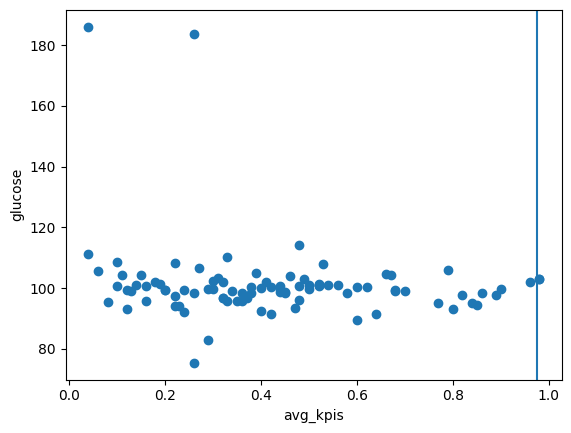

In [458]:
plot_multi_pareto_front(inference_df,control_cols,run)